# General data reader for AQUA 
## Example of datasets on Lumi

We added a few new data sources to the intake catalogue, pointing to resources already available on LUMI.

### Inspecting available datasets

Multiple datasets area available also for observations, so that we can also inspect the catalogue by checking what is inside. This can be done with the `inspect_catalogue` function

In [1]:
from aqua import catalogue, inspect_catalogue
from aqua import Reader
cat = catalogue()

IFS	tco79-eORCA1	tco79-eORCA1 data
	- atm2d	
	- atm3d	
IFS	fdb-tco399	fdb-long data tco399 grid
	- fdb-long-2d	FDB data tco399 grid
	- fdb-long-3d	FDB data tco399 grid
IFS	control-1950-devcon	FDB IFS/NEMO control run
	- hourly-native	hourly data on native grid TCo1279 (about 10km). Contains tprate(260048), 2t(167), 10u(165), 10v(166), 100u(228246), 100v(228247), sr(173), blh(159), 2d(168), skt(235), chnk(148). See fix yaml for derived vars.
	- hourly-1deg	hourly data on r100 grid. Contains tprate(260048), sf(144), 2t(167), 10u(165), blh(159), sshf(146), slhf(147), ssrd(169), ssr(176), strd(175), str(177), ttr(179), e(182), tsr(178), ewss(180), nsss(181), chnk(148), sro(8), ssro(9). See fix yaml for derived vars.
	- 6hourly-1deg	6hourly data on r100 grid. Contains z(129).
	- monthly-1deg-2d	monthly data on r100 grid. Contains tcc(164), sd(141), tciw(79), tclw(78), msl(151), tcwv(137), lcc(186), mcc(187), hcc(188).
	- monthly-1deg-3d	monthly data on r100 grid. Contains u(131), v(132), t(

Here below a short exploration at cataogue, model and experiment level

In [2]:
inspect_catalogue(cat)

Models available in catalogue:


['IFS',
 'FESOM',
 'NEMO',
 'ERA5',
 'MSWEP',
 'CERES',
 'PHC3',
 'WOA18',
 'OSI-SAF',
 'EN4',
 'AVISO']

In [3]:
inspect_catalogue(cat, model = 'IFS')

Experiments available in catalogue for model IFS:


['tco79-eORCA1',
 'fdb-tco399',
 'control-1950-devcon',
 'historical-1990-fesom',
 'historical-1990-devcon']

In [7]:
inspect_catalogue(cat, model = 'IFS', exp = 'control-1950-devcon')

Sources available in catalogue for model IFS and exp control-1950-devcon:


['hourly-native',
 'hourly-1deg',
 '6hourly-1deg',
 'monthly-1deg-2d',
 'monthly-1deg-3d',
 'lra-r100-monthly']

## FDB/GSV access

We implemented FDB access in the reader using the GSV reader interface and a new intake driver which we developed. Also in this case the idea is to 'shield' the users from complex mars-style requests, allowing them to focus on the desired variables and experiments.

IFS model is available in this format for the develpoment integrations, as well as two 'mock dataset' which uses ERA5 variables: the "fdb-test" dataset and a "fdb-long" datasets, including some common climate variables, for a few days (the former) and few years (the latter). as described in the [GSV Reader fdb-test documentation](https://earth.bsc.es/gitlab/digital-twins/de_340/gsv_interface/-/wikis/Specification-of-fdb-test) and [GSV Reader fdb-long documentation](https://earth.bsc.es/gitlab/digital-twins/de_340/gsv_interface/-/wikis/Specifications-of-fdb-long).

The default is now returning a standard dask-enabled xarray thanks to recent improvements to the interface which allow lazy dask access also for FDB/GSV data sources. It is still possible to obtain an iteratori instead, specifying the `streaming_generator=True` keyword.

Xarray/dask access (the default) is the recommended data access form, since it is the same used also for other data sources.

### Access to the fdb-test archive using dask

In [8]:
from aqua import Reader
reader = Reader(model="ERA5", exp="fdb", source="fdb-test")
data = reader.retrieve(var="tcc")

2023-10-11 17:12:33 :: Reader :: WARNING  -> No default fixes found! No fixes available for model ERA5, experiment fdb, source fdb-test


This produces a regular dask xarray Dataset:

In [9]:
data

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 720, time: 43393)
Coordinates:
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2025-01-01
Data variables:
    tcc      (time, lat, lon) float64 dask.array<chunksize=(24, 720, 1440), meta=np.ndarray>
Attributes:
    history:  2023-10-11 17:12:38 Dataset retrieved by GSV interface;\n2023-1...

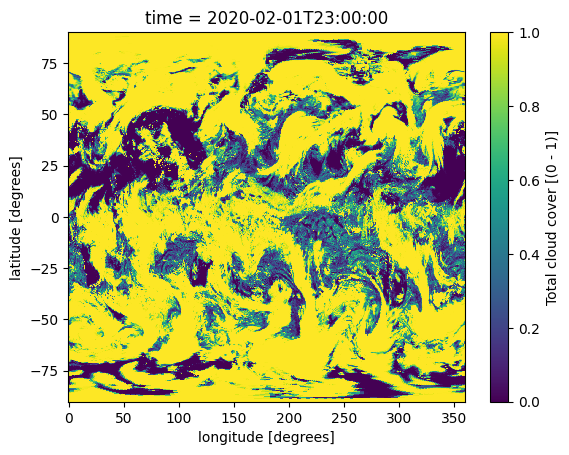

In [10]:
data.sel(time="20200201T2300").tcc.plot()

### Access to the fdb-test dataset using an iterator

It is also possible to get an iterator instead of a dask array using the keyword `streaming_generator=True`. For FDB sources this actually uses an iterator created directly by the GSV intake driver, instead of the streaming simulator. Notice the use, in this example, of the `aggregation` keyword, to specify aggregation/chunking, i.e. how much data to retrieve at each iteration. This keyword, if specified, has actually also a meaning for dask access, specifying chunk size, but is better to just use the defaults read from the catalogue and not to specify it. The defaults take into account memory limitations in chunking. Please check the documentation for further information on how to add a source from FDB.

In [11]:
from aqua import Reader
reader = Reader(model="ERA5", exp="fdb", source="fdb-test", regrid="r200", aggregation="D")

2023-10-11 17:13:43 :: Reader :: WARNING  -> No default fixes found! No fixes available for model ERA5, experiment fdb, source fdb-test


In [12]:
data = reader.retrieve(startdate="20200125", enddate="20200129", var="tcc", streaming_generator=True)

The result is now an 'iterator'

In [13]:
data

<generator object FixerMixin._fixergen at 0x7f5a99fa8240>

We can either loop over the iterator or just get the next value. It is only now that the reader will actually retrieve the field(s) from FDB:

In [14]:
data0 = next(data)

In [15]:
data0

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 720, time: 24)
Coordinates:
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * time     (time) datetime64[ns] 2020-01-25 ... 2020-01-25T23:00:00
Data variables:
    tcc      (time, lat, lon) float64 1.0 1.0 1.0 1.0 ... 0.9973 0.9973 0.9973
Attributes:
    history:  2023-10-11 17:14:21 Dataset retrieved by GSV interface;\n2023-1...

This is the first day. Let's instead loop over the next ones:

In [16]:
for d in data:
    dm = reader.fldmean(d).mean(dim="time").tcc
    print(dm.values)

0.6779889981482511
0.6780318111850079
0.680480838944271
0.6832746275494994


The generator is now exhausted, let's get a fresh one

In [17]:
data = reader.retrieve(startdate="20200401", enddate="20200404", var="tcc", streaming_generator=True)

In [18]:
data

<generator object FixerMixin._fixergen at 0x7f5a99fa9040>

The regridder can also operate on iterators:

In [19]:
datar = reader.regrid(data)
datar

<generator object Reader._regridgen at 0x7f5a99fcfca0>

In [20]:
next(datar)

<xarray.Dataset>
Dimensions:  (time: 24, lat: 90, lon: 180)
Coordinates:
  * time     (time) datetime64[ns] 2020-04-01 ... 2020-04-01T23:00:00
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Data variables:
    tcc      (time, lat, lon) float64 dask.array<chunksize=(24, 90, 180), meta=np.ndarray>
Attributes:
    history:  2023-10-11 17:14:53 Dataset retrieved by GSV interface;\n2023-1...

### Access to the fdb-long archive

It is possible also to access the [fdb-long archive](https://earth.bsc.es/gitlab/digital-twins/de_340/gsv_interface/-/wikis/Specifications-of-fdb-long).
By default the GSV interface prints information to screen but we suppress this. It can be reactivated with the option `verbose=True`.

In [22]:
from aqua import Reader
reader = Reader(model="IFS", exp="fdb-tco399", source="fdb-long-2d", aggregation="D", regrid="r025", verbose="True")
data = reader.retrieve(startdate='20200120', enddate='20200413', var='ci')

Request:  0 ['2t'] 0 23 {'domain': 'g', 'class': 'rd', 'expver': 'hz9n', 'type': 'fc', 'stream': 'lwda', 'anoffset': 9, 'date': '20200120', 'time': '0000', 'param': '2t', 'levtype': 'sfc', 'step': '0'}
Correctly decoded 2t     on level sfc    at 2020-01-20T00:00:00


2023-10-11 17:15:13 :: Reader :: WARNING  -> Weights file not found: /pfs/lustrep3/projappl/project_465000454/data/AQUA/weights/weights_tco399_ycon_r025_l2d.nc
2023-10-11 17:15:13 :: Reader :: WARNING  -> Attempting to generate it ...
2023-10-11 17:15:38 :: Reader :: WARNING  -> Success!
2023-10-11 17:15:38 :: Reader :: WARNING  -> Weights file not found: /pfs/lustrep3/projappl/project_465000454/data/AQUA/weights/weights_tco399_ycon_r025_l2dm.nc
2023-10-11 17:15:38 :: Reader :: WARNING  -> Attempting to generate it ...
2023-10-11 17:15:59 :: Reader :: WARNING  -> Success!


Request:  0 ['ci'] 0 23 {'domain': 'g', 'class': 'rd', 'expver': 'hz9n', 'type': 'fc', 'stream': 'lwda', 'anoffset': 9, 'date': '20200120', 'time': '0000', 'param': 'ci', 'levtype': 'sfc', 'step': '0'}
Correctly decoded ci     on level sfc    at 2020-01-20T00:00:00


Request:  0 ['ci'] 0 23 {'domain': 'g', 'class': 'rd', 'expver': 'hz9n', 'type': 'fc', 'stream': 'lwda', 'anoffset': 9, 'date': '20200120', 'time': '0000', 'param': 'ci', 'levtype': 'sfc', 'step': '0/to/23'}
Correctly decoded ci     on level sfc    at 2020-01-20T00:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T01:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T02:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T03:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T04:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T05:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T06:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T07:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T08:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T09:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T10:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T11:00:00
Correctly decoded ci    

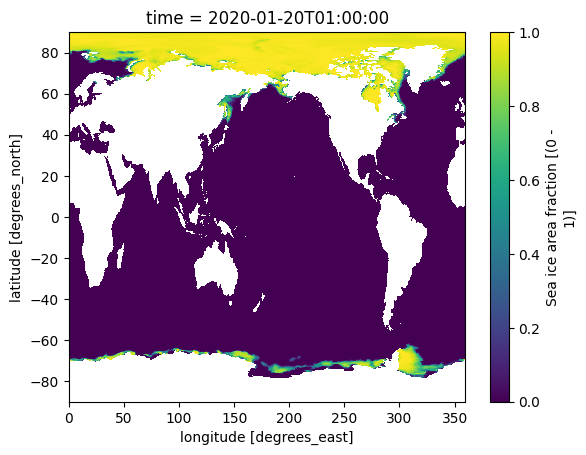

In [23]:
reader.regrid(data.ci.isel(time=1)).plot()

In [24]:
reader.fldmean(data.ci.isel(time=1)).values

Request:  0 ['ci'] 0 23 {'domain': 'g', 'class': 'rd', 'expver': 'hz9n', 'type': 'fc', 'stream': 'lwda', 'anoffset': 9, 'date': '20200120', 'time': '0000', 'param': 'ci', 'levtype': 'sfc', 'step': '0/to/23'}
Correctly decoded ci     on level sfc    at 2020-01-20T00:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T01:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T02:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T03:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T04:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T05:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T06:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T07:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T08:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T09:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T10:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T11:00:00
Correctly decoded ci    

array(0.0413731)

### Access to new IFS-NEMO control and historical runs on LUMI

The new sources have now been added to the catalogue and it is possible to read these data directly from the FDB through the reader

In [30]:
from aqua import Reader
reader = Reader(model='IFS', exp='control-1950-devcon', source='hourly-1deg')
data = reader.retrieve(var="2t")

The result is a dataset containing a dask DataArray for the full dataset:

In [31]:
data

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 181, time: 87648)
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 90.0 89.0 88.0 87.0 86.0 ... -87.0 -88.0 -89.0 -90.0
  * time     (time) datetime64[ns] 1950-01-01 ... 1959-12-31T23:00:00
Data variables:
    2t       (time, lat, lon) float64 dask.array<chunksize=(24, 181, 360), meta=np.ndarray>
Attributes:
    history:  2023-10-11 17:21:02 Dataset retrieved by GSV interface;\n2023-1...

We can now work on this as usual. For example this is the average over the month of January 1952:

In [32]:
data['2t'].sel(time=slice("19520101", "19520131T2300")).mean().values

array(276.59163528)

This took about 2m17s on LUMI. The data are represented by a dask xarray dataset, so if we use dask parallelism we can speed up things. Let us create a local cluster with 16 cores and two threads per core

In [1]:
from dask.distributed import LocalCluster, Client, progress
cluster = LocalCluster(ip="0.0.0.0", threads_per_worker=2, n_workers=16)
client = Client(cluster)
cluster

LocalCluster(7e3eae34, 'tcp://193.167.209.165:36859', workers=16, threads=32, memory=64.00 GiB)

Let's try again, this time with a cluster client

In [26]:
data['2t'].sel(time=slice("19520101", "19520131T2300")).mean().values

array(276.59163528)

Now it took only 23 seconds :)!

Finally, we read correctly also the monthly datasets (behind the scenes the date of these data is aligned so that it corresponds to the actual months): we can also retrieve multiple variables at the time.

In [33]:
from aqua import Reader
reader = Reader(model='IFS', exp='control-1950-devcon', source='monthly-1deg-2d')
data = reader.retrieve(var=["hcc", "lcc"])

In [34]:
data

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 181, time: 120)
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 90.0 89.0 88.0 87.0 86.0 ... -87.0 -88.0 -89.0 -90.0
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 1959-12-01
Data variables:
    hcc      (time, lat, lon) float64 dask.array<chunksize=(12, 181, 360), meta=np.ndarray>
    lcc      (time, lat, lon) float64 dask.array<chunksize=(12, 181, 360), meta=np.ndarray>
Attributes:
    history:  2023-10-11 17:24:19 Dataset retrieved by GSV interface;\n2023-1...

Final test: reading the historical simulation natively and converting it on the fly to a 2deg, daily averaged dataset:

In [12]:
from aqua import Reader
reader = Reader(model='IFS', exp='historical-1990-devcon', source='hourly-1deg', freq="daily", regrid="r200")
data = reader.retrieve(var="2t", regrid=True, timmean=True)

This is now an xarray of monthly means at low resolution. This took only a few seconds, since nothing has been computed yet (we are using dask)

In [13]:
data

<xarray.Dataset>
Dimensions:  (time: 365, lat: 90, lon: 180)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-12-31
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Data variables:
    2t       (time, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
Attributes:
    history:  2023-09-10 01:53:35 dataset retrieved by GSV interface;\n2023-0...

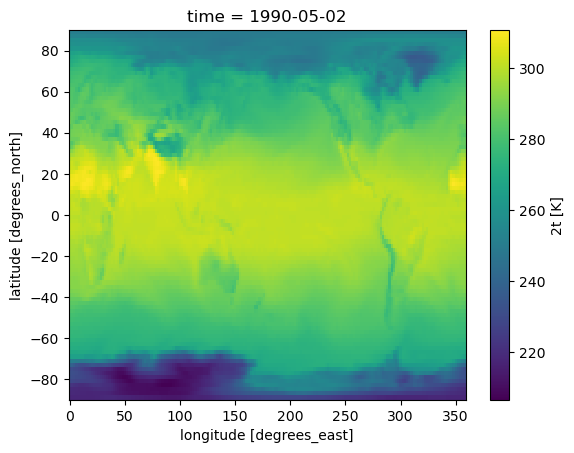

In [16]:
data['2t'].sel(time="19900502").plot()